# CNN

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Torchvision downloads the data to the current directory, keras caches it on the local machine. 

Torch vision could be used [like this](http://localhost:8923/doku.php?id=cifar-10):
    
```python
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision import transforms
 
# Prepare CIFAR-10 dataset, total 50k images.
dataset = CIFAR10(os.getcwd(), download=True, transform=transforms.ToTensor())
train_data,test_data = torch.utils.data.random_split(dataset,[40000,10000])
trainloader = torch.utils.data.DataLoader(train_data, batch_size=10, shuffle=True)
```

However large files will interfere with *Syncthing*, so we'll use *Keras* just to load the data:

In [2]:
from keras.datasets import mnist
from keras.datasets import cifar10


2022-10-07 23:21:53.407069: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-07 23:21:53.785137: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-07 23:21:53.785155: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-07 23:21:53.834270: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-07 23:21:55.355501: W tensorflow/stream_executor/platform/de

In [5]:
if torch.cuda.is_available():
    torch.device('cuda')
    print("CUDA")
else:
    torch.device('cpu')
    print("CPU")

CPU


In [6]:
(train_X, train_y), (test_X, test_y) = cifar10.load_data()
train_X = torch.from_numpy(train_X)
train_y = torch.from_numpy(train_y)

In [8]:
## This is a re-write of the architecture in the worksheets for AML
## Trying just a convolution --> flatted Dense layer

class cnn(nn.Module):
    def __init__(self):
        super(cnn, self).__init__()
        self.conv1 = nn.Conv2d(3,6,5)
        self.pool = nn.MaxPool2d(2,2)
        # self.fc1 = nn.Linear(6*28*28, 10)
        self.conv2 = nn.Conv2d(6,16,5)
        self.conv3=nn.Conv2d(16,8,3)
        self.fc1=nn.Linear(8*5*5, 120)
        self.fc2=nn.Linear(120,84)
        self.fc3=nn.Linear(84,10)
        self.do=nn.Dropout()
        self.pad=nn.ZeroPad2d(1)

    def forward (self, x):
        # x=F.relu(self.conv1(x))
        ## flattening the image atm 6x28x28
        # x = x.view(-1, 6*28*28)
        # x=self.fc1(x)

        x=self.pool(F.relu(self.conv1(x)))
        x=self.pool(F.relu(self.conv2(x)))
        x=self.pad(x)
        x=F.relu(self.conv3(x))
        # print(x.shape)
        x=x.view(-1,8*5*5)
        x=self.do(x)
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=self.fc3(x)
        return x

In [9]:
net = cnn()
net.train()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-4)

In [10]:
# train_X = train_X.reshape(32, 3, 32, -1)
## need to transpose to have the [sample, channel, x, y]
train_X = train_X.reshape(-1, 3, 32, 32)
train_X.shape

torch.Size([50000, 3, 32, 32])

In [11]:
## not batched
EPOCH=100
BATCH=512  # 12500
Loss=[]
LossEpoch=[]
AccuracyEpoch = []

for epoch in range(EPOCH):
    running_loss = 0.0
    running_accuracy=0.0
    b = np.random.randint(0, 50000, BATCH)
    for i in b:  #should be size of train, but I can't get the value out.
        inputs = train_X[i]
        labels = train_y[i]

        optimizer.zero_grad()

        outputs = net(inputs.float())
        _, pred=torch.max(outputs, 1)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        Loss.append(loss.item())
        running_loss += loss.item()
        running_accuracy += (pred==labels)
        
        # if i%1000 == 999:
        #     print('[%d, %5d] loss: %.3f' %
        #     (epoch + 1, i + 1, running_loss/1000))
        #     running_loss=0.0
    LossEpoch.append(running_loss/BATCH)   
    AccuracyEpoch.append(running_accuracy/BATCH)         
    print('[%2d] loss: %.3f \t accuracy: %.3f' % (epoch+1, running_loss/BATCH, running_accuracy/BATCH))

print('Finished Training')

plt.plot(LossEpoch)


[ 1] loss: 2.425 	 accuracy: 0.100
[ 2] loss: 2.301 	 accuracy: 0.100
[ 3] loss: 2.298 	 accuracy: 0.133
[ 4] loss: 2.304 	 accuracy: 0.096
[ 5] loss: 2.297 	 accuracy: 0.100
[ 6] loss: 2.285 	 accuracy: 0.125
[ 7] loss: 2.263 	 accuracy: 0.162
[ 8] loss: 2.265 	 accuracy: 0.156
[ 9] loss: 2.240 	 accuracy: 0.160
[10] loss: 2.262 	 accuracy: 0.164
[11] loss: 2.225 	 accuracy: 0.170
[12] loss: 2.243 	 accuracy: 0.137
[13] loss: 2.237 	 accuracy: 0.164
[14] loss: 2.189 	 accuracy: 0.170
[15] loss: 2.175 	 accuracy: 0.178
[16] loss: 2.174 	 accuracy: 0.180
[17] loss: 2.137 	 accuracy: 0.219
[18] loss: 2.167 	 accuracy: 0.188
[19] loss: 2.204 	 accuracy: 0.180
[20] loss: 2.125 	 accuracy: 0.184
[21] loss: 2.129 	 accuracy: 0.229
[22] loss: 2.100 	 accuracy: 0.248
[23] loss: 2.100 	 accuracy: 0.219
[24] loss: 2.109 	 accuracy: 0.211
[25] loss: 2.111 	 accuracy: 0.240
[26] loss: 2.070 	 accuracy: 0.223
[27] loss: 2.075 	 accuracy: 0.232
[28] loss: 2.050 	 accuracy: 0.248
[29] loss: 2.064 	 a

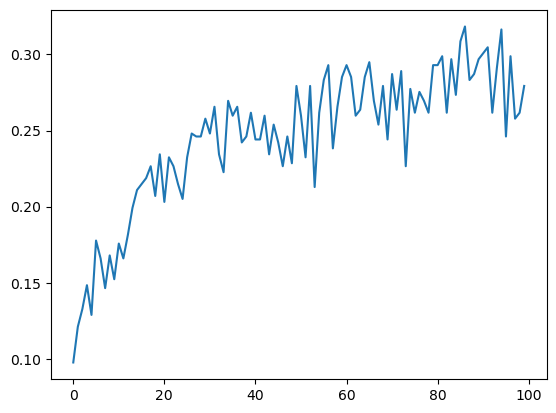

In [29]:
plt.plot(AccuracyEpoch)

In [30]:
classes=('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    ## I didn't normalise it
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg))
    # plt.imshow(npimg)
    plt.show()

In [24]:

# test_X = torch.from_numpy(test_X)
# test_y = torch.from_numpy(test_y)

test_X = test_X.reshape(-1, 3, 32, 32)
net.eval()
out = net(test_X[1].float())
_, pred = torch.max(out, 1)
pred

# classes[test_y[1]] == classes[pred]
classes[pred]

AttributeError: 'numpy.ndarray' object has no attribute 'float'